# Modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

import random
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from IPython.display import display, HTML

sys.path.append('..')
from models import utils
from sklearn.datasets import make_regression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


plt.rcParams.update(plt.rcParamsDefault)
plt.style.use(['ggplot', 'bmh'])
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

display_settings = {
    'max_columns': 999,
    'expand_frame_repr': True,
    'max_rows': 999,
    'precision': 4,
    'show_dimensions': True
}

%matplotlib inline

In [3]:
def fix_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    
fix_seeds()

# Models

## Linear regression with L2 regularization on weights (Ridge regression)

The linear regression model is defined as: $\hat{y} = w^{T} x + b$ where $\hat{y}$ is a scalar function to estimate.

Ordinary least squares with L2 regularization is the optimization problem defined as $ \min_{w, b} = \lVert X w - y \lVert_{2}^{2} + \lambda\lVert w \lVert_{2}^{2} $

It is explicitly solved as an analytical solution exists: $ w^{*} = (X^{T}X + \lambda I)^{-1} X^{T} y $

Model RMSE: 2.68


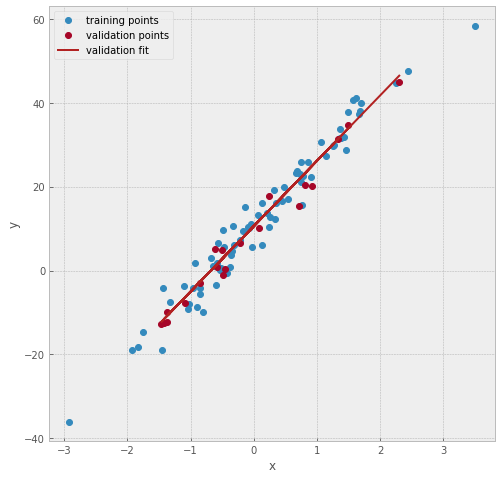

In [11]:
from models.linear_models import RidgeRegression


def rmse(y_true, y_hat):
    return np.sqrt(np.mean((y_true - y_hat)**2))

X, y = make_regression(n_samples=100, n_features=1, n_targets=1, bias=10, noise=3.)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

ridge_regressor = RidgeRegression()
ridge_regressor.fit(X_train, y_train)
y_hat = ridge_regressor.predict(X_val)

model_rmse = rmse(y_val, y_hat)

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(X_train, y_train, lw=0., marker='o', label='training points')
ax.plot(X_val, y_val, lw=0., marker='o', label='validation points')
ax.plot(X_val, y_hat, label='validation fit', c='firebrick')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.legend()
print(f'Model RMSE: {model_rmse:.2f}')

## Logistic regression

Logistic regression is a linear model used for binary classification (despite the "regression" term in its name). It is basically a linear regression model inside a sigmoid:

$ \hat{y} = z(w^{T}x + b) $ where $ z(x) = \frac{1}{1 + e^{-x}} $

The target $y$ is valued in $\{0, 1\}$ and represents a probability of a binary outcome. The sigmoid is used to transform the linear function output $ w^{T}x + b$ valued in $\{-\infty, \infty \} $ for a given sample to a probability.

The decision function parametrized by $ w $ and $ b $ is learned using Stochastic Gradient Descent (SGD) on the Binary Cross Entropy loss (BCE):

$ L(y; w, b) = \frac{1}{m} ( \, -y^{T} \log(\hat{y}) - (1 - y)^{T} \log(1 - \hat{y}) ) \, + \lambda R(w) $ where $ R(w) $ is a regularization term. Here, $l_{2}$ norm is chosen as regularization function.

SGD is an iterative procedure based on the gradient descent algorithm. At each iteration, model parameters are updated:
$ w^{(i+1)} = w^{(i)} - \eta * ( \lambda \frac{\partial R(w)}{\partial w} + \frac{\partial L(y; w, b)}{\partial w} ) $ where $ \eta $ is the learning rate.

In the case of the logistic regression, the weights update expression simplifies to 
$ w^{(i+1)} = w^{(i)} - \eta * ( 2 \lambda w + \frac{1}{m} X^{T} ( \hat{y} - y ) ) $

Model F1: 0.70


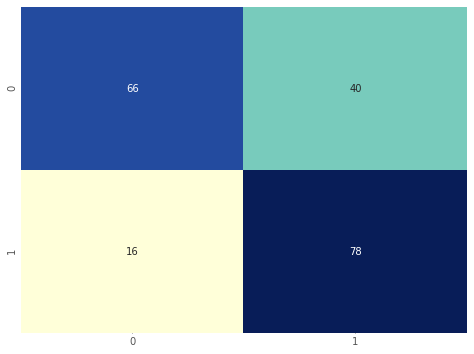

In [11]:
from models.linear_models import LogisticRegression


X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, n_classes=2)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

logistic_classfier = LogisticRegression()
logistic_classfier.fit(X_train, y_train)
y_hat = logistic_classfier.predict(X_val)

cm = utils.confusion_matrix(y_val, y_hat)
model_f1 = utils.f1_score(cm)
print(f'Model F1: {model_f1:.2f}')

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.0f', cbar=False, cmap='YlGnBu', ax=ax)

## K-NN regression (Euclidean distance)

Nearest neighbors methods are non parametric methods that are widely used both for supervised learning (regression and classification problems) and unsupervised, such as clustering. The base concept is to consider that the data lives on a flat manifold where close points w.r.t to some distance measure can be assumed to be similar. 

In the case of K-NN regression, the distribution that maps known data points $X$ to the target variable $y$ is interpolated using $k$ closest points using a proper distance metric:
* In the 'uniform' case, the prediction $\hat{y}$ for a new point $x$ is simply the average $y_{i}$ for every $i$ in the neighborhood of $x$ composed of the $k$ nearest points.
* In the 'distance' case, the predictions $\hat{y}$ is instead of a weighted average of $y_{i}$, where weights are the inverse of the distance to the new point $x$.

This is a naive implementation using a distance matrix $D = [ d_{ij} ]$ where $d_{ij}$ is the euclidean distance between known data points $x_{i}^{train}$ and a new point $x_{j}^{test}$. The use of the euclidean distance allow to implement the computation of this distance matrix by only using numpy optimized functions:
$ d_{ij}^{2} = - 2 X_{train} X_{test}^{T} + \sum_{k} (x_{ik}^{train})^{2} + \sum_{k} (x_{jk}^{test})^{2} $

K-NN classification is similar, differing on that instead of returning the average of the target over the neighbors, the classifier returns the most frequent class over the neighbors.

Text(0.5, 1.0, 'Inverse distance KNN interpolation')

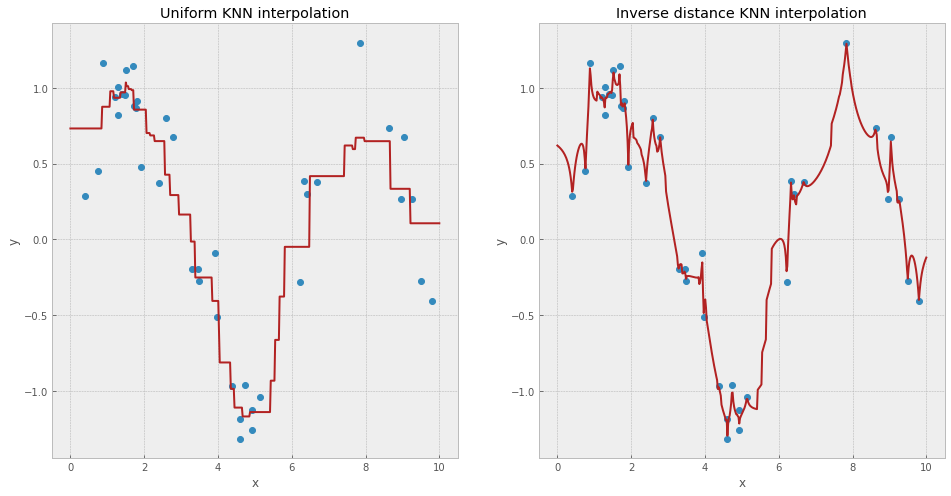

In [10]:
from models.knn import KNNRegressor
from sklearn.datasets import make_regression


X = np.sort(10 * np.random.rand(40, 1), axis=0)
X_test = np.linspace(0, 10, 500)[:, None]
y = np.sin(X).ravel() 
y = y + np.random.normal(0, .2, y.shape)

knn_regressor = KNNRegressor(weights='uniform')
knn_regressor.fit(X, y)
y_hat_uniform = knn_regressor.predict(X_test)

knn_regressor = KNNRegressor(weights='distance')
knn_regressor.fit(X, y)
y_hat_distance = knn_regressor.predict(X_test)

fig, (ax_uniform, ax_distance) = plt.subplots(ncols=2, figsize=(16, 8))
ax_uniform.plot(X, y, lw=0., marker='o')
ax_uniform.plot(X_test, y_hat_uniform, c='firebrick')
ax_uniform.set_xlabel('x')
ax_uniform.set_ylabel('y')
ax_uniform.set_title('Uniform KNN interpolation')

ax_distance.plot(X, y, lw=0., marker='o')
ax_distance.plot(X_test, y_hat_distance, c='firebrick')
ax_distance.set_xlabel('x')
ax_distance.set_ylabel('y')
ax_distance.set_title('Inverse distance KNN interpolation')

## Decision trees classifier

Decisions trees are binary trees where each node splits a feature given a threshold that minimizes a criterion, and which is learned during training. By essence, this process is recursive.

Given $(X^{r}, y^{r})$ at each recursion step $r$, information gains between $y^{r}$ of the current node and all the combinations $y_{i,t}^{r}$ where $i$ is the i-th feature and t the threshold to test the split on are computed. The best (feature, threshold) found then define the next split. For a branch, the process continues until the maximum depth is reached, or if all the labels are the same.

The information gain is defined as $ IG(y, y_{left}, y_{right}) = loss(y) - \frac{1}{N_{left} + N_{right}} ( N_{left} \cdot loss (y_{left}) + N_{right} \cdot loss (y_{right})) $ where $y_{left/right}$ are the labels of the samples split w.r.t a given threshold on a given feature, and $N_{left/right}$ are the number of labels in each groups. It is basically a loss difference where the child losses are weighted.

The loss used for classification is usually the entropy (information theory one) defined as $ E(y) = - \sum_{i \in C} p_{i} \log_{2} p_{i} $ over the classes $C$, where $p_{i} $ is simply the fraction of labels of class $c_{i}$ in the group.

To make predictions, the tree is traversed for each new points until it reaches a leaf. The most common class inside the leaf is returned as the predicted value.

This model can be used for regression to: instead of the entropy loss, the mean squared error can be used and instead of storing probabilities of the targets in the leafs, the average value of the targets is stores.

Model F1: 0.85


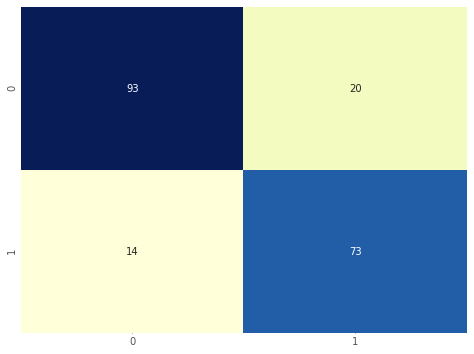

In [335]:
from models.trees import DecisionTreeClassifier


X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, n_classes=2)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

dt_classfier = DecisionTreeClassifier()
dt_classfier.fit(X_train, y_train)
y_hat = dt_classfier.predict(X_val)

cm = utils.confusion_matrix(y_val, y_hat)
model_f1 = utils.f1_score(cm)
print(f'Model F1: {model_f1:.2f}')

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.0f', cbar=False, cmap='YlGnBu', ax=ax)

## Random forest

Random forests are a natural extension of decision trees: instead of learning one tree on the dataset, random forests train $N_{T}$ trees on a subset of the original dataset. Each tree learns decision rules on a boostraped version of the original dataset (sampling with replacement on the samples) and on a subset of the feature space (features bagging). 

At inference time, predictions of each trees of the forest are aggregated to supply the final prediction: either by averaging in the case of regressions, or by taking the most frequent class in the case of classification problems.

Feature bagging prevents the trees to be highly correlated if a few features are strong predictors of the target. Bootstraping allow to make the model more robust to noise as long as trees are not strongly correlated and avoid ending up with strongly correlated trees, simply because they are trained on different subsets of the original dataset.

Model F1: 0.88


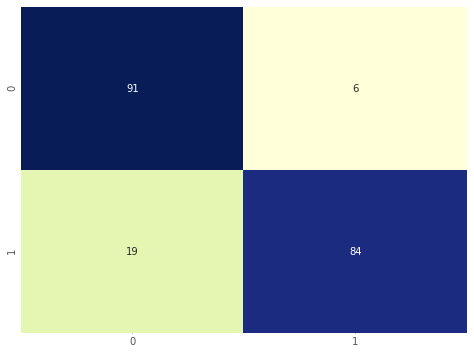

In [435]:
from models.trees import RandomForestClassifier


X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, n_classes=2)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

rf_classfier = RandomForestClassifier(n_trees=10)
rf_classfier.fit(X_train, y_train)
y_hat = rf_classfier.predict(X_val)

cm = utils.confusion_matrix(y_val, y_hat)
model_f1 = utils.f1_score(cm)
print(f'Model F1: {model_f1:.2f}')

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.0f', cbar=False, cmap='YlGnBu', ax=ax)
